<a href="https://colab.research.google.com/github/suleymanerpak/Tweet-Sentiment-Classification/blob/main/Tweet_Sentiment_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/Colab Notebooks/cleaned_tweet_sentiment.csv"
df = pd.read_csv(file_path)

print("Veri ön izlemesi:")
print(df.head())
df = df.drop_duplicates()

Mounted at /content/drive
Veri ön izlemesi:
                           tweet sentiment
0      The event starts at 5 PM.   neutral
1    I hate how this turned out.  negative
2          Fantastic experience!  positive
3  This is the worst thing ever!  negative
4          What a wonderful day!  positive


In [ ]:
import re

def temizle(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+|\#", '', text)
    text = re.sub(r"[^a-zA-Z\s]", '', text)
    text = re.sub(r"\s+", ' ', text).strip()
    return text

# Tüm harfleri küçük yapar. Linkleri siler. @kullanici etiketlerini siler.
# Harf ve boşluk dışındaki her şeyi siler (noktalar, emojiler, sayılar vb.).
# Birden fazla boşluğu tek boşluk haline getirir ve baştaki/sondaki boşlukları kaldırır.


df['clean_tweet'] = df['tweet'].apply(temizle)
print("\nTemizlenmiş Tweet Örneği:")
print(df[['tweet', 'clean_tweet']].head())


Temizlenmiş Tweet Örneği:
                           tweet                   clean_tweet
0      The event starts at 5 PM.        the event starts at pm
1    I hate how this turned out.    i hate how this turned out
2          Fantastic experience!          fantastic experience
3  This is the worst thing ever!  this is the worst thing ever
4          What a wonderful day!          what a wonderful day


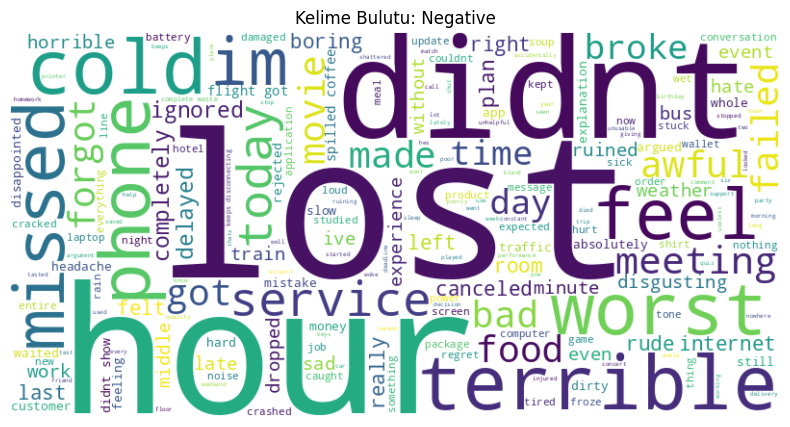

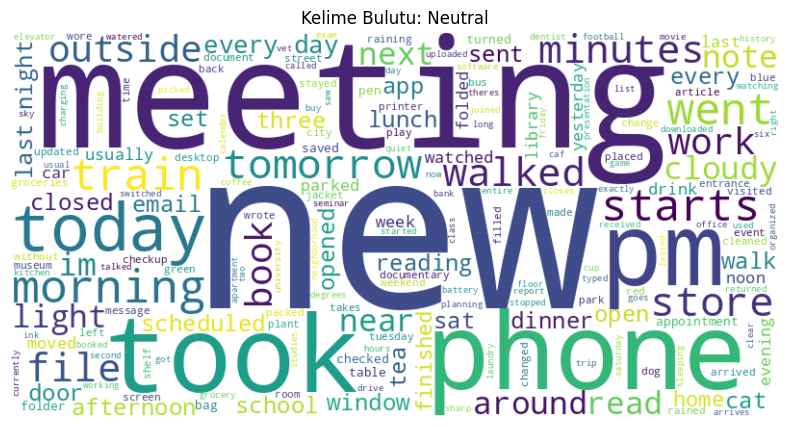

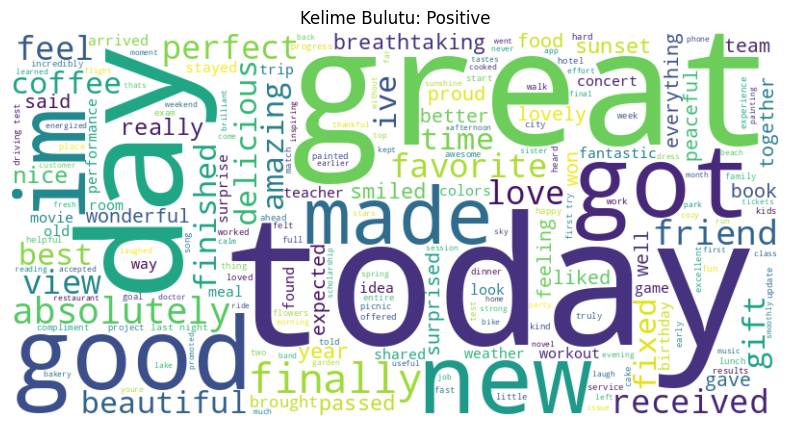

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Kelime bulutu oluşturur
def plot_wordcloud_for_sentiment(df, sentiment_label):
    text = ' '.join(df[df['sentiment'] == sentiment_label]['clean_tweet'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.title(f'Kelime Bulutu: {sentiment_label.capitalize()}')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Her duygu için kelime bulutu çizer
for sentiment in ['negative', 'neutral', 'positive']:
    plot_wordcloud_for_sentiment(df, sentiment)

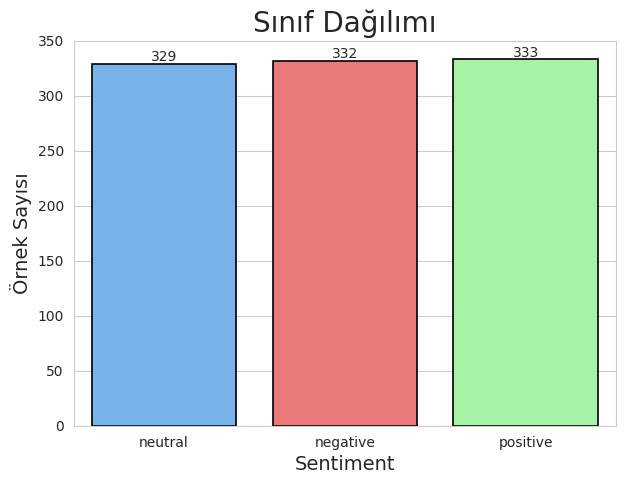

In [ ]:
# Bar Plot ile Görselleştirme
import seaborn as sns

sns.set_style("whitegrid")

renkler = {
    'positive': '#99ff99',
    'negative': '#ff6666',
    'neutral': '#66b3ff'
}

plt.figure(figsize=(7,5))
ax = sns.countplot(x='sentiment', data=df,
                   hue='sentiment',
                   palette=renkler,
                   legend=False,
                   edgecolor='black', linewidth=1.2)

plt.title("Sınıf Dağılımı", fontsize=20)
plt.xlabel("Sentiment", fontsize=14)
plt.ylabel("Örnek Sayısı", fontsize=14)
plt.ylim(0,350)

for p in ax.patches:
    ax.annotate(format(int(p.get_height()), 'd'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5), textcoords='offset points')

plt.show()

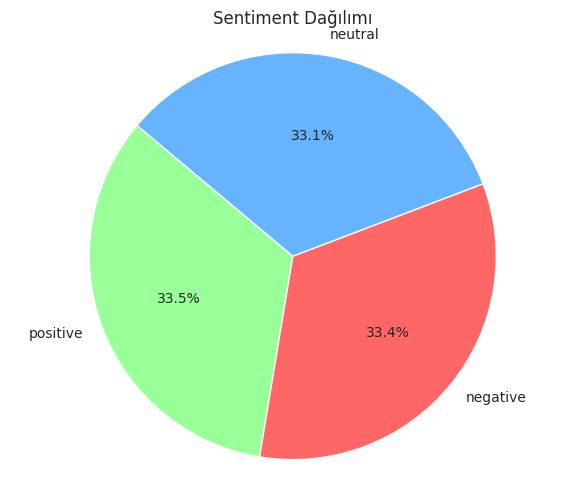

In [ ]:
# Pie Chart ile Görselleştirme
sentiment_counts = df['sentiment'].value_counts()

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['#99ff99','#ff6666','#66b3ff'])
plt.title('Sentiment Dağılımı')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Metin verilerini sayısal formata çevirir
# ngram_range=(1,2): hem unigram (tek kelime) hem de bigram (iki kelimelik) ifadeleri dikkate alır
# max_features=5000: en fazla 5000 en sık geçen kelime/bigram alınır
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=5000)
# Temizlenmiş tweet metinlerini vektöre dönüştürür
X = vectorizer.fit_transform(df['clean_tweet'])
y = df['sentiment']

print("TF-IDF matris boyutu:", X.shape)

TF-IDF matris boyutu: (994, 4530)


In [ ]:
from sklearn.model_selection import train_test_split

# Veriyi eğitim ve test olarak ikiye ayırır
# 42 sayısı gelenektir
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import numpy as np

# X_train seyrek (sparse) matris olduğu için sadece dolu veriler tutulur
# Burada bu hücreler arasında kaç tanesi NaN (eksik) kontrol edilir
print("NaN sayısı:", np.isnan(X_train.data).sum())

# Eğer varsa NaN olan hücreleri 0 ile değiştirir (çünkü model NaN ile çalışamaz)
X_train.data = np.nan_to_num(X_train.data)

NaN sayısı: 0


Fitting 3 folds for each of 8 candidates, totalling 24 fits

✅ En iyi doğruluk skoru (cross-validation): 0.7786
✅ En iyi parametreler: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}

📊 Test Seti Doğruluğu: 0.7889

Sınıflandırma Raporu:
               precision    recall  f1-score   support

    negative       0.82      0.78      0.80        68
     neutral       0.76      0.83      0.79        64
    positive       0.80      0.76      0.78        67

    accuracy                           0.79       199
   macro avg       0.79      0.79      0.79       199
weighted avg       0.79      0.79      0.79       199



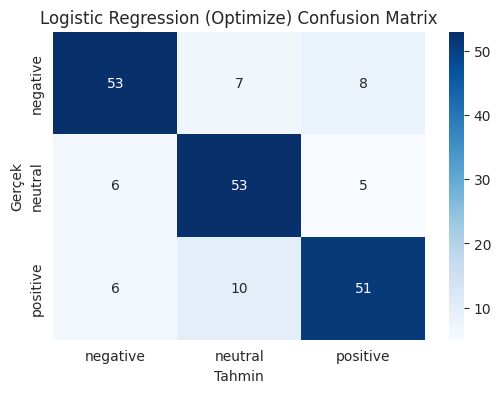

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Hiperparametre aralığı belirlenir
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga']
}

log_model = LogisticRegression(max_iter=1000, class_weight='balanced')
# max_iter=1000: maksimum iterasyon sayısı / class_weight='balanced': dengesiz veri varsa sınıflara ağırlık verir

# GridSearchCV ile parametre kombinasyonlarını deneyerek en iyisini buluruz
grid = GridSearchCV(estimator=log_model,
                    param_grid=param_grid,
                    cv=3,
                    scoring='accuracy',
                    verbose=1,
                    n_jobs=-1)

# Eğit
grid.fit(X_train, y_train)

# En iyi skor ve parametreleri göster
print("\n✅ En iyi doğruluk skoru (cross-validation):", round(grid.best_score_, 4))
print("✅ En iyi parametreler:", grid.best_params_)

# En iyi modeli al
best_log_model = grid.best_estimator_

# Test verisi üzerinde dene
from sklearn.metrics import classification_report, accuracy_score

y_pred = best_log_model.predict(X_test)
print("\n📊 Test Seti Doğruluğu:", round(accuracy_score(y_test, y_pred), 4))
print("\nSınıflandırma Raporu:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=best_log_model.classes_)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_log_model.classes_, yticklabels=best_log_model.classes_)
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.title('Logistic Regression (Optimize) Confusion Matrix')
plt.show()

Random Forest Doğruluk Oranı: 0.7185929648241206

Random Forest Sınıflandırma Raporu:
               precision    recall  f1-score   support

    negative       0.73      0.71      0.72        68
     neutral       0.70      0.75      0.72        64
    positive       0.73      0.70      0.72        67

    accuracy                           0.72       199
   macro avg       0.72      0.72      0.72       199
weighted avg       0.72      0.72      0.72       199



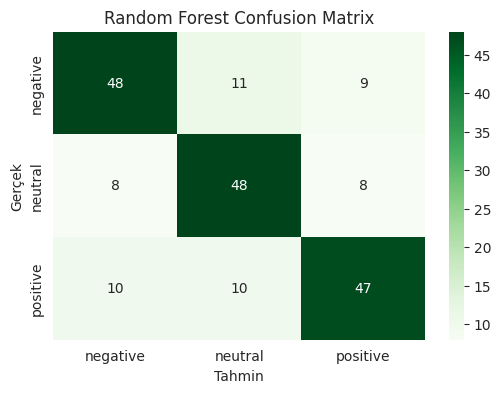

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Modeli oluştur
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Eğit
rf_model.fit(X_train, y_train)

# Tahmin yap
y_pred_rf = rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Doğruluk Oranı:", accuracy_rf)

print("\nRandom Forest Sınıflandırma Raporu:\n", classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf, labels=rf_model.classes_)

plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.title('Random Forest Confusion Matrix')
plt.show()

Fitting 3 folds for each of 36 candidates, totalling 108 fits

✅ En iyi doğruluk skoru (cross-validation): 0.7862
✅ En iyi parametreler: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}

📊 Test Seti Doğruluğu: 0.799

Sınıflandırma Raporu:
               precision    recall  f1-score   support

    negative       0.84      0.82      0.83        68
     neutral       0.75      0.80      0.77        64
    positive       0.81      0.78      0.79        67

    accuracy                           0.80       199
   macro avg       0.80      0.80      0.80       199
weighted avg       0.80      0.80      0.80       199



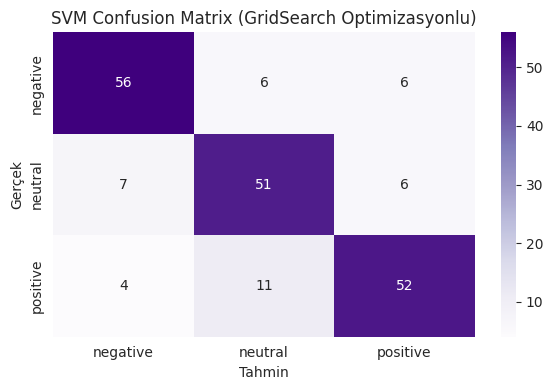

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Hiperparametre aralığı
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3]
}

# Model
svm_model = SVC(class_weight='balanced', probability=True)

# GridSearchCV ile parametre kombinasyonlarını deneyerek en iyisini buluruz
grid_svm = GridSearchCV(estimator=svm_model,
                        param_grid=param_grid,
                        cv=3,
                        scoring='accuracy',
                        verbose=1,
                        n_jobs=-1)

# Eğit
grid_svm.fit(X_train, y_train)

# En iyi sonuç
print("\n✅ En iyi doğruluk skoru (cross-validation):", round(grid_svm.best_score_, 4))
print("✅ En iyi parametreler:", grid_svm.best_params_)

# En iyi model
best_svm_model = grid_svm.best_estimator_

# Tahmin
y_pred_svm = best_svm_model.predict(X_test)

# Test doğruluğu ve rapor
print("\n📊 Test Seti Doğruluğu:", round(accuracy_score(y_test, y_pred_svm), 4))
print("\nSınıflandırma Raporu:\n", classification_report(y_test, y_pred_svm))

cm_svm = confusion_matrix(y_test, y_pred_svm, labels=best_svm_model.classes_)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Purples',
            xticklabels=best_svm_model.classes_,
            yticklabels=best_svm_model.classes_)
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.title('SVM Confusion Matrix (GridSearch Optimizasyonlu)')
plt.tight_layout()
plt.show()


✅ En iyi doğruluk skoru (cross-validation): 0.7887
✅ En iyi parametreler: {'alpha': 0.1}

📊 Test Seti Doğruluğu: 0.8141

Sınıflandırma Raporu:
               precision    recall  f1-score   support

    negative       0.82      0.87      0.84        68
     neutral       0.80      0.80      0.80        64
    positive       0.83      0.78      0.80        67

    accuracy                           0.81       199
   macro avg       0.81      0.81      0.81       199
weighted avg       0.81      0.81      0.81       199



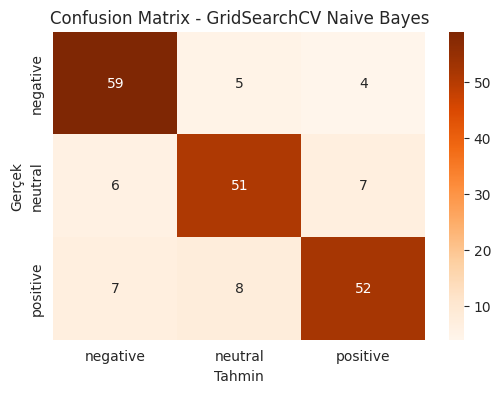

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Naive Bayes için test edilecek alpha değerleri
param_grid = {'alpha': [0.01, 0.05, 0.1, 0.5, 1]}

# GridSearchCV ile parametre kombinasyonlarını deneyerek en iyisini buluruz
grid = GridSearchCV(MultinomialNB(), param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

# En iyi modeli al
best_nb_model = grid.best_estimator_

# Tahmin yap
y_pred = best_nb_model.predict(X_test)


# Doğruluk
print(f"\n✅ En iyi doğruluk skoru (cross-validation): {round(grid.best_score_, 4)}")
print("✅ En iyi parametreler:", grid.best_params_)
print("\n📊 Test Seti Doğruluğu:", round(accuracy_score(y_test, y_pred), 4))
print("\nSınıflandırma Raporu:\n", classification_report(y_test, y_pred))

# Konfüzyon matrisi
cm = confusion_matrix(y_test, y_pred, labels=best_nb_model.classes_)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=best_nb_model.classes_, yticklabels=best_nb_model.classes_)
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix - GridSearchCV Naive Bayes')
plt.show()


Model: LogisticRegression
Doğruluk (Accuracy): 0.7889

Sınıflandırma Raporu:
               precision    recall  f1-score   support

    negative       0.82      0.78      0.80        68
     neutral       0.76      0.83      0.79        64
    positive       0.80      0.76      0.78        67

    accuracy                           0.79       199
   macro avg       0.79      0.79      0.79       199
weighted avg       0.79      0.79      0.79       199



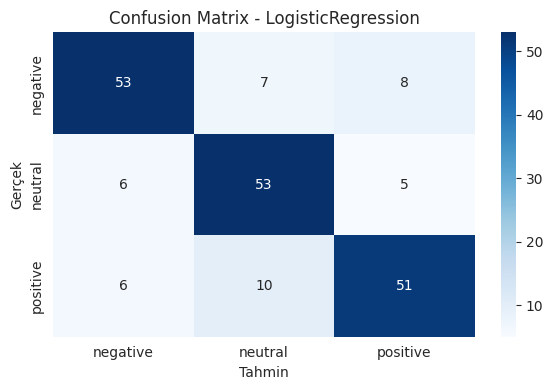


Model: RandomForestClassifier
Doğruluk (Accuracy): 0.7186

Sınıflandırma Raporu:
               precision    recall  f1-score   support

    negative       0.73      0.71      0.72        68
     neutral       0.70      0.75      0.72        64
    positive       0.73      0.70      0.72        67

    accuracy                           0.72       199
   macro avg       0.72      0.72      0.72       199
weighted avg       0.72      0.72      0.72       199



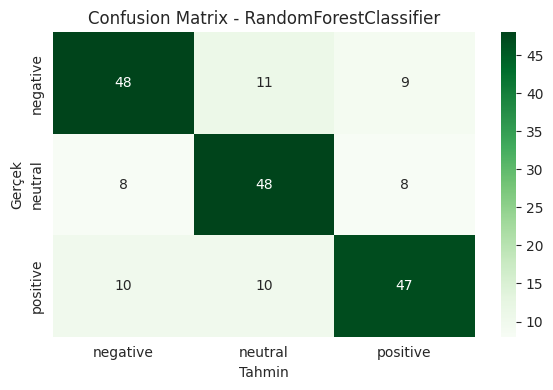


Model: SVC
Doğruluk (Accuracy): 0.7990

Sınıflandırma Raporu:
               precision    recall  f1-score   support

    negative       0.84      0.82      0.83        68
     neutral       0.75      0.80      0.77        64
    positive       0.81      0.78      0.79        67

    accuracy                           0.80       199
   macro avg       0.80      0.80      0.80       199
weighted avg       0.80      0.80      0.80       199



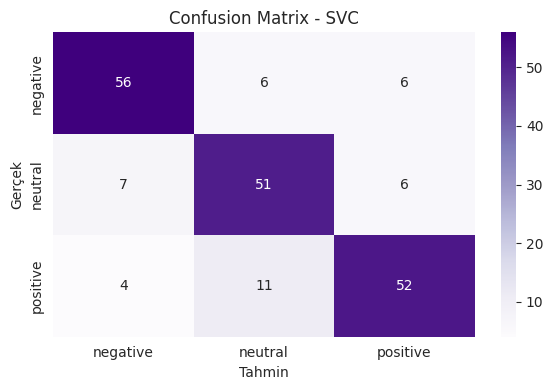


Model: MultinomialNB (GridSearchCV)
Doğruluk (Accuracy): 0.8141

Sınıflandırma Raporu:
               precision    recall  f1-score   support

    negative       0.82      0.87      0.84        68
     neutral       0.80      0.80      0.80        64
    positive       0.83      0.78      0.80        67

    accuracy                           0.81       199
   macro avg       0.81      0.81      0.81       199
weighted avg       0.81      0.81      0.81       199



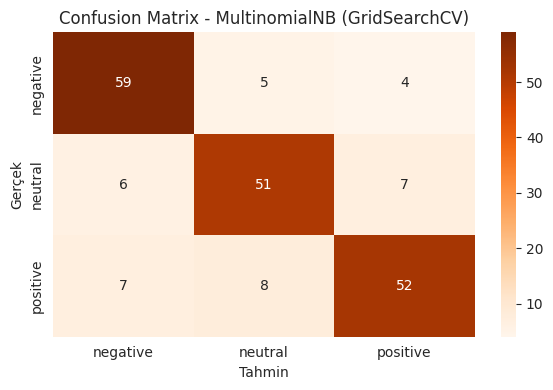


📊 Modeller Karşılaştırma Tablosu:

                          Model  Accuracy  Precision_Positive  Recall_Positive  F1_Positive
0            LogisticRegression    0.7889              0.7969           0.7612       0.7786
1        RandomForestClassifier    0.7186              0.7344           0.7015       0.7176
2                           SVC    0.7990              0.8125           0.7761       0.7939
3  MultinomialNB (GridSearchCV)    0.8141              0.8254           0.7761       0.8000

                          Model  Precision_Neutral  Recall_Neutral  F1_Neutral
0            LogisticRegression             0.7571          0.8281      0.7910
1        RandomForestClassifier             0.6957          0.7500      0.7218
2                           SVC             0.7500          0.7969      0.7727
3  MultinomialNB (GridSearchCV)             0.7969          0.7969      0.7969

                          Model  Precision_Negative  Recall_Negative  F1_Negative
0            LogisticRegr

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Pandas ayarları
pd.set_option("display.precision", 4)
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', None)


# Model analiz fonksiyonu
def model_analiz_ve_raporla(model, X_train, y_train, X_test, y_test):
    model_adi = model.__class__.__name__
    if isinstance(model, MultinomialNB) and hasattr(model, 'alpha') and model.alpha != 1.0:
        model_adi += " (GridSearchCV)"
        cmap = 'Oranges'
    elif model_adi == "LogisticRegression":
        cmap = 'Blues'
    elif model_adi == "RandomForestClassifier":
        cmap = 'Greens'
    elif model_adi == "SVC":
        cmap = 'Purples'
    else:
        cmap = 'Blues'

    print(f"\nModel: {model_adi}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"Doğruluk (Accuracy): {acc:.4f}")
    print("\nSınıflandırma Raporu:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel('Tahmin')
    plt.ylabel('Gerçek')
    plt.title(f'Confusion Matrix - {model_adi}')
    plt.tight_layout()
    plt.show()

    rapor = classification_report(y_test, y_pred, output_dict=True)
    return {
        'Model': model_adi,
        'Accuracy': round(acc, 4),
        'Precision_Positive': round(rapor['positive']['precision'], 4),
        'Recall_Positive': round(rapor['positive']['recall'], 4),
        'F1_Positive': round(rapor['positive']['f1-score'], 4),
        'Precision_Neutral': round(rapor['neutral']['precision'], 4),
        'Recall_Neutral': round(rapor['neutral']['recall'], 4),
        'F1_Neutral': round(rapor['neutral']['f1-score'], 4),
        'Precision_Negative': round(rapor['negative']['precision'], 4),
        'Recall_Negative': round(rapor['negative']['recall'], 4),
        'F1_Negative': round(rapor['negative']['f1-score'], 4)
    }

# Modeller listesi
modeller = [
    best_log_model,
    rf_model,
    best_svm_model,
    best_nb_model
]

# Analiz ve karşılaştırma
sonuclar = []
for model in modeller:
    sonuc = model_analiz_ve_raporla(model, X_train, y_train, X_test, y_test)
    sonuclar.append(sonuc)

# Sonuçları DataFrame olarak yazdır
df = pd.DataFrame(sonuclar)
print("\n📊 Modeller Karşılaştırma Tablosu:\n")
print(df[['Model', 'Accuracy', 'Precision_Positive', 'Recall_Positive', 'F1_Positive']])
print()
print(df[['Model', 'Precision_Neutral', 'Recall_Neutral', 'F1_Neutral']])
print()
print(df[['Model', 'Precision_Negative', 'Recall_Negative', 'F1_Negative']])

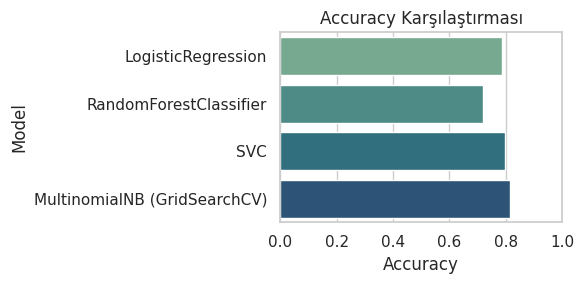

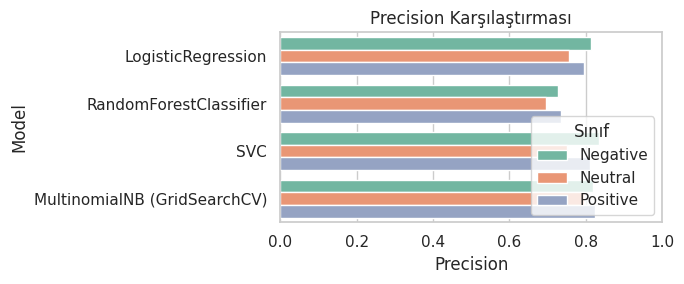

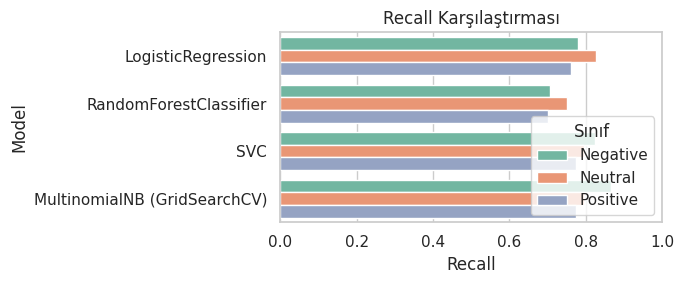

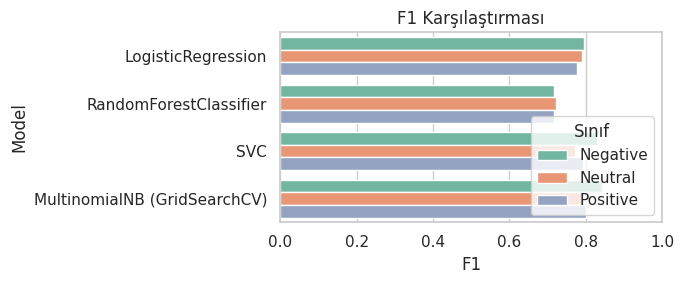

In [ ]:
# Bar Plot ile Görselleştirme
# Tema
sns.set(style="whitegrid")

# Metrikleri uzun forma dönüştür
def melt_metrics(df, metric_type):
    columns = [f"{metric_type}_Negative", f"{metric_type}_Neutral", f"{metric_type}_Positive"]
    return df.melt(
        id_vars="Model",
        value_vars=columns,
        var_name="Sınıf",
        value_name=metric_type
    )

# Accuracy için ayrı grafik
plt.figure(figsize=(6, 3))
sns.barplot(x="Accuracy", y="Model", hue="Model", data=df, palette="crest", legend=False)
plt.title("Accuracy Karşılaştırması")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

# Precision, Recall, F1 için ayrı ayrı küçük grafikler
for metrik in ["Precision", "Recall", "F1"]:
    df_melted = melt_metrics(df, metrik)
    df_melted["Sınıf"] = df_melted["Sınıf"].str.replace(f"{metrik}_", "")  # 'Precision_Positive' -> 'Positive'

    plt.figure(figsize=(7, 3))
    sns.barplot(x=metrik, y="Model", hue="Sınıf", data=df_melted, palette="Set2")
    plt.title(f"{metrik} Karşılaştırması")
    plt.xlim(0, 1)
    plt.legend(title="Sınıf", loc="lower right")
    plt.tight_layout()
    plt.show()

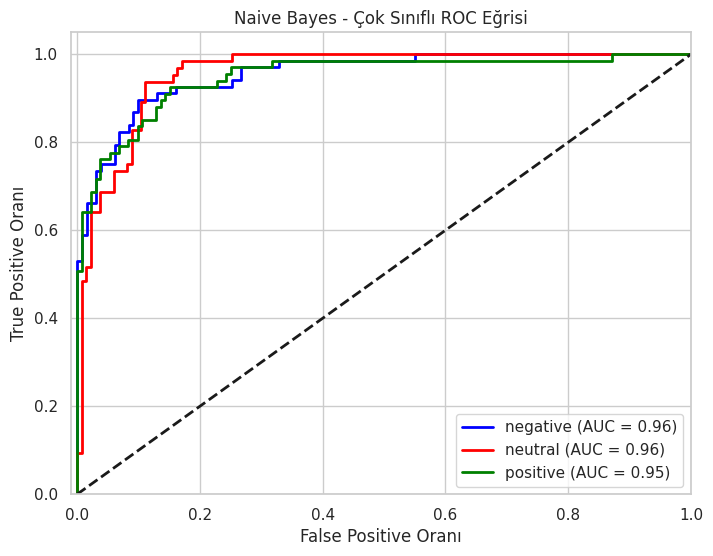

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# ROC (Receiver Operating Characteristic) eğrisi, bir sınıflandırma modelinin başarısını görselleştirir.
# Her sınıf için modelin ne kadar iyi doğru pozitif (TPR) ve yanlış pozitif (FPR) oranı yakaladığını gösterir.
# X ekseni: False Positive Rate (Yanlış pozitif oranı), Y ekseni: True Positive Rate (Gerçek pozitif oranı = Recall)
# ROC eğrisi ne kadar sol üst köşeye yakınsa, model o kadar başarılıdır.
# Eğrinin altında kalan alan (AUC = Area Under Curve) ne kadar büyükse, modelin ayrım gücü o kadar iyidir.
# AUC skoru 1'e yaklaştıkça mükemmel model, 0.5 ise rastgele tahmin anlamına gelir.


# Naive Bayes modelinden olasılık tahminleri
y_score = best_nb_model.predict_proba(X_test)

# Gerçek etiketleri ikili (one-hot) formata çevirir
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

# Sınıf isimleri
classes = lb.classes_

# Renk döngüsü
colors = cycle(['blue', 'red', 'green'])

# ROC eğrisini çizer
plt.figure(figsize=(8, 6))

for i, color in zip(range(len(classes)), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

# Rastgele tahmin çizgisi
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Oranı')
plt.ylabel('True Positive Oranı')
plt.title('Naive Bayes - Çok Sınıflı ROC Eğrisi')
plt.legend(loc="lower right")
plt.show()

In [ ]:
models = [
    ("Logistic Regression", LogisticRegression(max_iter=1000, class_weight='balanced')),
    ("Random Forest", RandomForestClassifier(class_weight='balanced')),
    ("SVM", SVC(class_weight='balanced', probability=True)),
    ("Naive Bayes", MultinomialNB())
]

# Gerçek etiketleri düzgün biçimde bastır
print("🎯 Gerçek Etiketler (y_test[:10]):", ' | '.join(y_test[:10].values))
print("--------------------------------------------------------------")

# Her model için ilk 10 tahmini bastır
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name:<20} Tahminleri: {' | '.join(y_pred[:10])}")

🎯 Gerçek Etiketler (y_test[:10]): positive | negative | negative | neutral | negative | negative | positive | neutral | neutral | positive
--------------------------------------------------------------
Logistic Regression  Tahminleri: positive | neutral | negative | negative | negative | neutral | positive | negative | neutral | positive
Random Forest        Tahminleri: negative | neutral | negative | negative | neutral | neutral | positive | negative | negative | positive
SVM                  Tahminleri: positive | neutral | negative | negative | negative | negative | positive | negative | neutral | positive
Naive Bayes          Tahminleri: positive | neutral | negative | negative | neutral | negative | positive | negative | neutral | positive


In [ ]:
def tahmini_modelle_karsilastir(X_train, y_train, vectorizer):
    tweet = input("📥 Bir tweet girin: ")
    cleaned = temizle(tweet)
    vectorized = vectorizer.transform([cleaned])

    modeller = [
        ("Logistic Regression", LogisticRegression(max_iter=1000, class_weight='balanced')),
        ("Random Forest", RandomForestClassifier(class_weight='balanced')),
        ("SVM", SVC(class_weight='balanced', probability=True)),
        ("Naive Bayes", MultinomialNB())
    ]

    print(f"\n🔎 Girdi: {tweet}")
    print(f"🧼 Temizlenmiş: {cleaned}")
    print("--------------------------------------------------")

    for isim, model in modeller:
        model.fit(X_train, y_train)
        tahmin = model.predict(vectorized)
        print(f"{isim:<20} ➜ Tahmin edilen duygu: {tahmin[0]}")

tahmini_modelle_karsilastir(X_train, y_train, vectorizer)

📥 Bir tweet girin: What a fantastic performance from Messi!

🔎 Girdi: What a fantastic performance from Messi!
🧼 Temizlenmiş: what a fantastic performance from messi
--------------------------------------------------
Logistic Regression  ➜ Tahmin edilen duygu: positive
Random Forest        ➜ Tahmin edilen duygu: positive
SVM                  ➜ Tahmin edilen duygu: positive
Naive Bayes          ➜ Tahmin edilen duygu: positive
